In [78]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import enet_path
from scipy.sparse import spdiags,eye,csc_matrix, diags
from scipy.sparse.linalg import spsolve
import csv

# Generate data

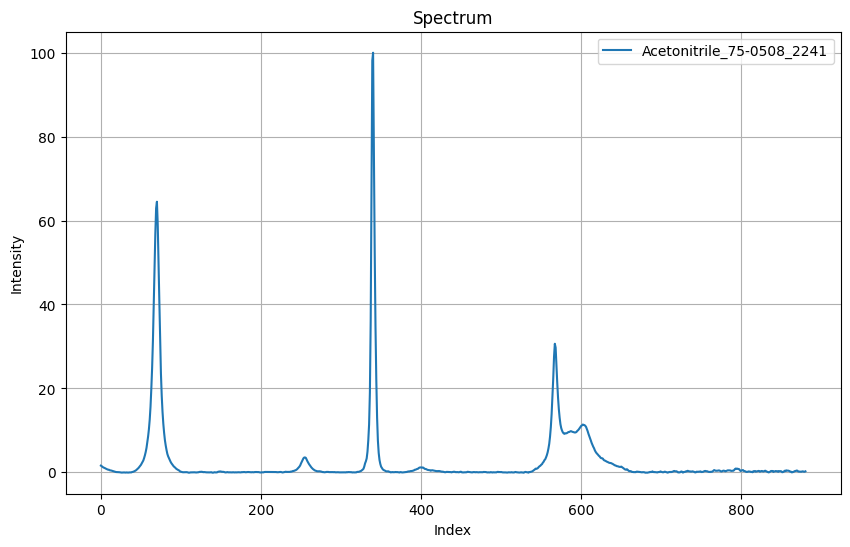

In [79]:
def WhittakerSmooth(x, lamb, w):
        m = w.shape[0]
        W = spdiags(w, 0, m, m)
        D = eye(m - 1, m, 1) - eye(m - 1, m)
        return spsolve((W + lamb * D.transpose() * D), w * x)


def airPLS(x, lamb=10, itermax=10):
        m = x.shape[0]
        w = np.ones(m)
        for i in range(itermax):
            z = WhittakerSmooth(x, lamb, w)
            d = x - z
            if sum(abs(d[d < 0])) < 0.001 * sum(abs(x)):
                break;
            w[d < 0] = np.exp(i * d[d < 0] / sum(d[d < 0]))
            w[d >= 0] = 0
        return z


def airPLS_MAT(X, lamb=10, itermax=10):
        B = X.copy()
        for i in range(X.shape[0]):
            B[i,] = airPLS(X[i,], lamb, itermax)
        return X - B

    
def WhittakerSmooth_MAT(X, lamb=1):
        C = X.copy()
        w = np.ones(X.shape[1])
        for i in range(X.shape[0]):
            C[i,] = WhittakerSmooth(X[i, :], lamb, w)
    
        return C

# Import Data
# Database
datafile0 = u'./data/database_for_Liquid_and_powder_mixture.npy'
spectrum_pure = np.load(datafile0)

# Component information of database
csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
DBcoms = [row for row in csv_reader]


spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)

# Chuẩn hóa
for i in range(spectrum_pure.shape[0]):
         spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100

for i, idx in enumerate(DBcoms):
        plt.figure(figsize=(10, 6))
        plt.plot(spectrum_pure[i, :], label=idx[0])
        plt.xlabel('Index')
        plt.ylabel('Intensity')
        plt.title(f'Spectrum')
        plt.legend()
        plt.grid(True)
        plt.show()

In [80]:
# Assuming spectrum_pure is loaded from a file
spectrum_pure = np.load(datafile0)[1:3, :880]  # Use only the second and third spectra (indices 1 and 2) and 880 data points

def make_data_denoise(spectrum_pure, num_samples=15000, channels=2, length=880, width=1):
    # Scale the spectra
    for i in range(spectrum_pure.shape[0]):
        spectrum_pure[i, :] = spectrum_pure[i, :] * 10

    # Initialize the dataset with only one component since we're not mixing spectra
    dataset = np.zeros((num_samples, 1, channels, length, width))
    labels = []

    for i in range(num_samples):
        # Choose a random pure spectrum between spectrum 1 and 2
        pure_index = np.random.choice(2, 1, replace=False)  # Only choose between index 0 and 1 in the subset
        label = np.zeros(2)  
        label[pure_index] = 1
        labels.append(label)

        # Get the pure spectrum and add noise
        pure_spectrum = spectrum_pure[pure_index[0]]
        noisy_spectrum = pure_spectrum + np.random.normal(0, 1, size=len(pure_spectrum))

        # Normalize both spectra
        pure_spectrum = pure_spectrum / np.max(pure_spectrum) 
        noisy_spectrum = noisy_spectrum / np.max(noisy_spectrum) 

        # Store the spectra in the dataset
        dataset[i, 0, 0, :, :] = pure_spectrum.reshape((880, 1))
        dataset[i, 0, 1, :, :] = noisy_spectrum.reshape((880, 1))

    labels = np.array(labels)
    
    # Check the shape of dataset and labels
    print("Dataset shape:", dataset.shape)
    print("Labels shape:", labels.shape)

    # Save dataset, labels
    np.save('./data/dataset_noise_pure_182.npy', dataset)
    np.save('./data/labels_noise_pure_182.npy', labels)

# Run the function
make_data_denoise(spectrum_pure)


Dataset shape: (15000, 1, 2, 880, 1)
Labels shape: (15000, 2)


In [81]:
def poly_baseline(x):
    p = np.random.uniform(1, 3)
    intensity = np.random.uniform(0.5, 1.5)
    b = np.random.uniform(-0.3, 0.3)
    y = (x / len(x)) ** p
    return (y / y.max()) * intensity + b 

def negative_poly_baseline(x):
    p = np.random.uniform(1, 3)
    intensity = np.random.uniform(0.5, 1.5)
    b = np.random.uniform(-0.3, 0.3)
    y = (x / len(x)) ** p
    return -(y / y.max()) * intensity + b

def gaussian_baseline(x):
    mean = np.random.uniform(0, 50)
    sd = np.random.uniform(150, 250)
    intensity = np.random.uniform(0.5, 1.5)
    b = np.random.uniform(-0.3, 0.3)
    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
    return (y / y.max()) * intensity + b

# Additional baselines combining polynomial and Gaussian (optional)
# def pg_baseline(x):
#     p = np.random.uniform(1, 3)
#     intensity1, intensity2 = np.random.uniform(0.5, 1.5, 2)
#     mean, sd = np.random.uniform(0, 50), np.random.uniform(400, 550)
#     b = np.random.uniform(-0.3, 0.3)
#     y1 = (x / len(x)) ** p
#     y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
#     return (y1 / y1.max() * intensity1 + y2 / y2.max() * intensity2) + b
# 
# def pd_baseline(x):
#     p1, p2 = np.random.uniform(1, 3, 2)
#     intensity1, intensity2 = np.random.uniform(0.5, 1.5, 2)
#     b = np.random.uniform(-0.3, 0.3)
#     y1 = (x / len(x)) ** p1
#     y2 = -(x / len(x)) ** p2 + 1
#     return (y1 / y1.max() * intensity1 + y2 / y2.max() * intensity2) + b
# 
# def dg_baseline(x):
#     p = np.random.uniform(1, 3)
#     intensity1, intensity2 = np.random.uniform(0.5, 1.5, 2)
#     mean, sd = np.random.uniform(0, 50), np.random.uniform(400, 550)
#     b = np.random.uniform(-0.3, 0.3)
#     y1 = -(x / len(x)) ** p + 1
#     y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
#     return (y1 / y1.max() * intensity1 + y2 / y2.max() * intensity2) + b
# 
# def pdg_baseline(x):
#     p1, p2 = np.random.uniform(1, 3, 2)
#     intensity1, intensity2, intensity3 = np.random.uniform(0.5, 1.5, 3)
#     mean, sd = np.random.uniform(0, 50), np.random.uniform(400, 550)
#     b = np.random.uniform(-0.3, 0.3)
#     y1 = (x / len(x)) ** p1
#     y2 = -(x / len(x)) ** p2 + 1
#     y3 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
#     return (y1 / y1.max() * intensity1 + y2 / y2.max() * intensity2 + y3 / y3.max() * intensity3) + b
# 
# def polynomial_baseline(x):
#     a, b, c, d, e = np.random.uniform(-1e-3, 1e-3, 5)
#     y = a * x**4 + b * x**3 + c * x**2 + d * x + e
#     return y
# 
# def polynomial_baseline2(x):
#     a, b, c, d, e, f = np.random.uniform(-1e-3, 1e-3, 6)
#     y = a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f
#     return y

# Generate spectrum with multiple baseline functions and output baseline labels
def generate_spectrum(input, num_baselines=2):
    x_range = np.linspace(0, input.shape[0] - 1, input.shape[0])
    
    while True:
        baseline_labels = np.random.randint(0, 2, size=num_baselines) 
        if np.any(baseline_labels != 0):  # Exit if at least one value is not 0
            break

    baselines = [poly_baseline, gaussian_baseline]

    # Ensure noisy_spectrum and applied_baselines are one-dimensional
    noisy_spectrum = np.copy(input).flatten()
    applied_baselines = np.zeros_like(noisy_spectrum)

    for i in range(num_baselines):
        if baseline_labels[i] == 1:
            baseline_func = baselines[i]
            baseline = baseline_func(x_range).flatten()
            noisy_spectrum += baseline
            applied_baselines += baseline

    return noisy_spectrum, baseline_labels, applied_baselines


In [82]:
num_samples = 5000
all_noisy_spectra = []
all_baseline_labels = []
all_baseline_applied = []

# Load dataset
Input_Data = './data/dataset_noise_pure_182.npy'
Inputs = np.load(Input_Data)

Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
for inputs in Inputs:
    noisy_spectrum, baseline_labels, baseline_applied = generate_spectrum(inputs[1, : , :], num_baselines=2)
    all_baseline_labels.append(baseline_labels)  
    all_noisy_spectra.append(noisy_spectrum.flatten())  #
    all_baseline_applied.append(baseline_applied.flatten())

# Chuyển đổi danh sách thành mảng numpy
all_baseline_labels = np.array(all_baseline_labels)
all_noisy_spectra = np.array(all_noisy_spectra)
all_baseline_applied = np.array(all_baseline_applied)

# Tạo DataFrame từ dữ liệu
df_labels = pd.DataFrame(all_baseline_labels)  # Tạo DataFrame cho labels
df_spectra = pd.DataFrame(all_noisy_spectra)  # Tạo DataFrame cho dữ liệu spectrum
df_basline = pd.DataFrame(all_baseline_applied)

# Kết hợp DataFrame cho labels và dữ liệu spectrum
df = pd.concat([df_labels, df_spectra, df_basline], axis=1)

# Lưu DataFrame vào file CSV
df.to_csv('./data/Baseline_noise_182.csv', index=False)


In [83]:
num_samples = 3200
all_noisy_spectra = []
all_baseline_labels = []
all_baseline_applied = []

# Load dataset
Input_Data = './data/dataset_noise_pure_182.npy'
Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])

# Sinh 3200 mẫu
sample_count = 0
for inputs in Inputs:
    if sample_count >= num_samples:
        break
    noisy_spectrum, baseline_labels, baseline_applied = generate_spectrum(inputs[1, :, :], num_baselines=2)
    
    all_baseline_labels.append(baseline_labels.flatten())
    all_noisy_spectra.append(noisy_spectrum.flatten())
    all_baseline_applied.append(baseline_applied.flatten())
    
    sample_count += 1  # Tăng số lượng mẫu đã sinh lên 1

# Chuyển đổi danh sách thành mảng numpy
all_baseline_labels = np.array(all_baseline_labels)
all_noisy_spectra = np.array(all_noisy_spectra)
all_baseline_applied = np.array(all_baseline_applied)

print(all_baseline_applied.shape)

# Tạo DataFrame từ dữ liệu
df_labels = pd.DataFrame(all_baseline_labels)  # Tạo DataFrame cho labels
df_spectra = pd.DataFrame(all_noisy_spectra)  # Tạo DataFrame cho dữ liệu spectrum
df_basline = pd.DataFrame(all_baseline_applied)

# Kết hợp DataFrame cho labels và dữ liệu spectrum
df = pd.concat([df_labels, df_spectra, df_basline], axis=1)

# Lưu DataFrame vào file CSV
df.to_csv('./data/Baseline_test_182.csv', index=False)
print('ok')


(3200, 880)
ok


In [84]:
# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_noise_182.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")
# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

# Hiển thị kích thước của x_train và y_train+
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("baseline_train:", baseline_train.shape)

Đọc dữ liệu
x_train: (15000, 880)
y_train: (15000, 2)
baseline_train: (15000, 880)


In [87]:
def ConvClassifica():
    input = tf.keras.layers.Input((880,))
    input_reshaped = tf.keras.layers.Reshape((880, 1))(input)  # Reshape to (880, 1) for Conv1D compatibility
    conv1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, activation='relu')(input_reshaped)
    pool1 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2)(conv1)
    flatten = tf.keras.layers.Flatten()(pool1)
    fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    fc2 = tf.keras.layers.Dense(2, activation='softmax')(fc1)  # Set units=3 and activation='softmax' for 3 classes
    model = tf.keras.Model(inputs=input, outputs=fc2)
    return model

model = ConvClassifica()

model.summary()
# model.load_weights('model_1811.weights.h5')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 880)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 880, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 876, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 438, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 7008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │       700,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,198 (2.67 MB)

 Trainable params: 701,198 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
spectra_num = len(x_train)
train_split = round(0.8 * spectra_num)
val_split = round(0.2 * spectra_num)

x_trainn = x_train[:train_split]
x_test = x_train[train_split:train_split + val_split]

y_trainn = y_train[:train_split]
y_test = y_train[train_split:train_split + val_split]

# Create Dataset for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((x_trainn, y_trainn)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Define custom Hamming loss functions
def Custom_Hamming_Loss(y_true, y_pred):
    return K.mean(y_true * (1 - y_pred) + (1 - y_true) * y_pred)

def Custom_Hamming_Loss1(y_true, y_pred):
    tmp = K.abs(y_true - y_pred)
    return K.mean(K.cast(K.greater(tmp, 0.5), dtype=tf.float32))

# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Custom_Hamming_Loss, Custom_Hamming_Loss1])

# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50)

# Save the model weights
model.save_weights('./model_182.weights.h5')


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7061 - custom__hamming__loss: 0.1699 - custom__hamming__loss1: 0.1699 - loss: 2.6283e-04 - val_accuracy: 0.6973 - val_custom__hamming__loss: 0.1661 - val_custom__hamming__loss1: 0.1661 - val_loss: 0.0026
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6826 - custom__hamming__loss: 0.1699 - custom__hamming__loss1: 0.1699 - loss: 0.0027 - val_accuracy: 0.7117 - val_custom__hamming__loss: 0.1661 - val_custom__hamming__loss1: 0.1661 - val_loss: 9.1572e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7001 - custom__hamming__loss: 0.1699 - custom__hamming__loss1: 0.1699 - loss: 8.1316e-05 - val_accuracy: 0.7280 - val_custom__hamming__loss: 0.1661 - val_custom__hamming__loss1: 0.1661 - val_loss: 5.2385e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7100 - custom__hamming__loss: 0.1701 - custom__hamming__loss1: 0.1701 - loss: 7.9938e-05 - val_accuracy: 0.7163 - val_

In [91]:
sample_index = 80
sample_data = x_train[sample_index]

sample_data = tf.expand_dims(sample_data, axis=0)  

predicted_output = model.predict(sample_data)
print("Ground True output for sample", y_train[sample_index])
print("Predicted output for sample", sample_index, ":", predicted_output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Ground True output for sample tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Predicted output for sample 80 : [[0. 1.]]


In [92]:
def negative_poly_baseline(x, p, intensity, b):
    y = -(x / len(x)) ** p
    return (y / y.max() if y.max() != 0 else y) * intensity + b 

def poly_baseline(x, p, intensity, b):
    y = (x / len(x)) ** p
    return (y / y.max() if y.max() != 0 else y) * intensity + b 

def gaussian_baseline(x, mean, sd, intensity, b):
    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
    return (y / y.max() if y.max() != 0 else y) * intensity + b 

def pg_baseline(x, p, in1, mean, sd, in2, b):
    y1 = (x / len(x)) ** p
    y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
    return ((y1 / y1.max() if y1.max() != 0 else y1) * in1 + (y2 / y2.max() if y2.max() != 0 else y2) * in2) + b

def pd_baseline(x, p1, in1, p2, in2, b):
    y1 = (x / len(x)) ** p1
    y2 = -(x / len(x)) ** p2 + 1
    return ((y1 / y1.max() if y1.max() != 0 else y1) * in1 + (y2 / y2.max() if y2.max() != 0 else y2) * in2) + b

def dg_baseline(x, p, in1, mean, sd, in2, b):
    y1 = -(x / len(x)) ** p + 1
    y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
    return ((y1 / y1.max() if y1.max() != 0 else y1) * in1 + (y2 / y2.max() if y2.max() != 0 else y2) * in2) + b

def pdg_baseline(x, p1, in1, p2, in2, mean, sd, in3, b):
    y1 = (x / len(x)) ** p1
    y2 = -(x / len(x)) ** p2 + 1
    y3 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi))
    return ((y1 / y1.max() if y1.max() != 0 else y1) * in1 + (y2 / y2.max() if y2.max() != 0 else y2) * in2 + (y3 / y3.max() if y3.max() != 0 else y3) * in3) + b

def mix_min(sp, baseline, Previous_Dev):
    condition1 = (sp > baseline)
    condition1_2 = (sp < baseline + Previous_Dev)
    condition2_2 = (baseline - Previous_Dev < sp)
    new_baseline = np.where(condition1, np.where(condition1_2, sp, baseline + Previous_Dev), np.where(condition2_2, baseline - Previous_Dev, sp))
    return new_baseline

def iterative_fitting_with_bounds(sp, ite, threshold=0.005):
    """
    Parameters:
        sp (np.array): Original spectral data.
        ite (int): Number of iterations.
        threshold (float, optional): Convergence threshold for early stopping. Default is 0.005.

    Returns:
        np.array: Final fitted baseline after iterative adjustments.
    """
    x = np.linspace(1, 880, 880)  
    tempb = sp.copy()
    Previous_Dev = float('inf')  
    fitted_baseline = np.zeros(880)
    
    torch_tempb = np.expand_dims(tempb, axis=0)
   
    for i in range(ite):
        tadvice = model(torch_tempb)  # Get advice from the model
        # Get advice from the model
        # Select baseline function based on tadvice values
        if tadvice[0][0] > 0.4 and tadvice[0][1] > 0.4:
            p, _ = curve_fit(
                pg_baseline, x, tempb,
                bounds=([1, 0.5, 0, 150, 0.5, -0.3], [3, 1.5, 50, 250, 1.5, 0.3])
            )
            fitted_baseline = pg_baseline(x, *p)
        elif tadvice[0][0] > 0.4:
            p, _ = curve_fit(
                poly_baseline, x, tempb,
                bounds=([1, 0.5, -0.3], [3, 1.5, 0.3])
            )
            fitted_baseline = poly_baseline(x, *p)
        elif tadvice[0][1] > 0.4:
            p, _ = curve_fit(
                gaussian_baseline, x, tempb,
                bounds=([0, 150, 0.5, -0.3], [50, 250, 2, 0.3])
            )
            fitted_baseline = gaussian_baseline(x, *p)
        
        # # Handle cases when no dominant tadvice
        if max(tadvice[0]) <= 0.4:
             if tadvice[0][0] < 0.05 and tadvice[0][1] > 0.05:
                 p, _ = curve_fit(
                     gaussian_baseline, x, tempb,
                     bounds=([0, 150, 0.5, -0.3], [50, 250, 2, 0.3])
                 )
                 fitted_baseline = gaussian_baseline(x, *p)
             elif tadvice[0][1] < 0.05 and tadvice[0][0] > 0.05:
                 p, _ = curve_fit(
                     poly_baseline, x, tempb,
                     bounds=([1, 0.5, -0.3], [3, 2, 0.3])
                 )
                 fitted_baseline = poly_baseline(x, *p)
             elif tadvice[0][1] > 0.05 and tadvice[0][0] > 0.05:
                 p, _ = curve_fit(
                     pg_baseline, x, tempb,
                     bounds=([1, 0.5, 0, 150, 0.5, -0.3], [3, 1.5, 50, 250, 1.5, 0.3])
                 )
                 fitted_baseline = pg_baseline(x, *p)
             elif all(t < 0.05 for t in tadvice[0]):
                 fitted_baseline = np.zeros(880)  # Zero baseline when all tadvice values are very low

        # Update spectral values for the next iteration
        Dev = np.std(tempb - fitted_baseline)
        tempb = mix_min(sp, fitted_baseline, Dev)
        
        torch_tempb = np.expand_dims(tempb, axis=0)

        # Check early stopping condition
        if i > 0 and np.abs((Dev - Previous_Dev) / Dev) < threshold:
            break
        Previous_Dev = Dev

    return fitted_baseline

In [93]:
def mix_min_no(sp, baseline):
    new_baseline = np.minimum(baseline,sp)    
    return new_baseline

def iterative_fitting_with_bounds_no(sp, ite):
    x = np.linspace(1, 880, 880)  # Ensure x has 880 points
    tempb = sp
    i = 0
    fitted_baseline = np.zeros(880)
    torch_tempb = tf.expand_dims(tempb, axis=0)
   
        
    while i < ite:
        tadvice = model(torch_tempb)  # Get advice from the model
        # Get advice from the model
        # Select baseline function based on tadvice values
        if tadvice[0][0] > 0.4 and tadvice[0][1] > 0.4:
            p, _ = curve_fit(
                pg_baseline, x, tempb,
                bounds=([1, 0.5, 0, 150, 0.5, -0.3], [3, 1.5, 50, 250, 1.5, 0.3])
            )
            fitted_baseline = pg_baseline(x, *p)
        elif tadvice[0][0] > 0.4:
            p, _ = curve_fit(
                poly_baseline, x, tempb,
                bounds=([1, 0.5, -0.3], [3, 1.5, 0.3])
            )
            fitted_baseline = poly_baseline(x, *p)
        elif tadvice[0][1] > 0.4:
            p, _ = curve_fit(
                gaussian_baseline, x, tempb,
                bounds=([0, 150, 0.5, -0.3], [50, 250, 2, 0.3])
            )
            fitted_baseline = gaussian_baseline(x, *p)
        
        # # Handle cases when no dominant tadvice
        if max(tadvice[0]) <= 0.4:
             if tadvice[0][0] < 0.05 and tadvice[0][1] > 0.05:
                 p, _ = curve_fit(
                     gaussian_baseline, x, tempb,
                     bounds=([0, 150, 0.5, -0.3], [50, 250, 2, 0.3])
                 )
                 fitted_baseline = gaussian_baseline(x, *p)
             elif tadvice[0][1] < 0.05 and tadvice[0][0] > 0.05:
                 p, _ = curve_fit(
                     poly_baseline, x, tempb,
                     bounds=([1, 0.5, -0.3], [3, 2, 0.3])
                 )
                 fitted_baseline = poly_baseline(x, *p)
             elif tadvice[0][1] > 0.05 and tadvice[0][0] > 0.05:
                 p, _ = curve_fit(
                     pg_baseline, x, tempb,
                     bounds=([1, 0.5, 0, 150, 0.5, -0.3], [3, 1.5, 50, 250, 1.5, 0.3])
                 )
                 fitted_baseline = pg_baseline(x, *p)
             elif all(t < 0.05 for t in tadvice[0]):
                 fitted_baseline = np.zeros(880)  # Zero baseline when all tadvice values are very low
         
        tempb = mix_min_no(tempb, fitted_baseline)
        tempb_np = np.array(tempb)
        # Convert to tensor
        torch_tempb = tempb_np.reshape(1, 880)

   
        if(max(tadvice[0])<0.01):
            break
        i += 1

    return tempb

In [94]:
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

# Khởi tạo một số hàm khử nhiễu dao động
def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    E=eye(m,format='csc')
    for i in range(differences):
        E=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*E.T*E))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z


In [99]:
# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_test_182.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")

# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train và baseline_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

Input_Data = './data/dataset_noise_pure_182.npy'

Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
print(Inputs.shape)
input1 = Inputs[:,0,:,-1]
print(input1.size)
input2 = Inputs[:,1,:,-1]

Đọc dữ liệu
(15000, 2, 880, 1)
13200000


Sample 1:
RMSE - Our method with bounds: 0.3391, Based method with bounds: 0.3418, Imodpoly: 0.0263, airPLS: 0.0807
SNR after Baseline Removal - Our method with bounds: 0.0970, Based method with bounds: 0.0955, Imodpoly: 16.1655, airPLS: 1.7134


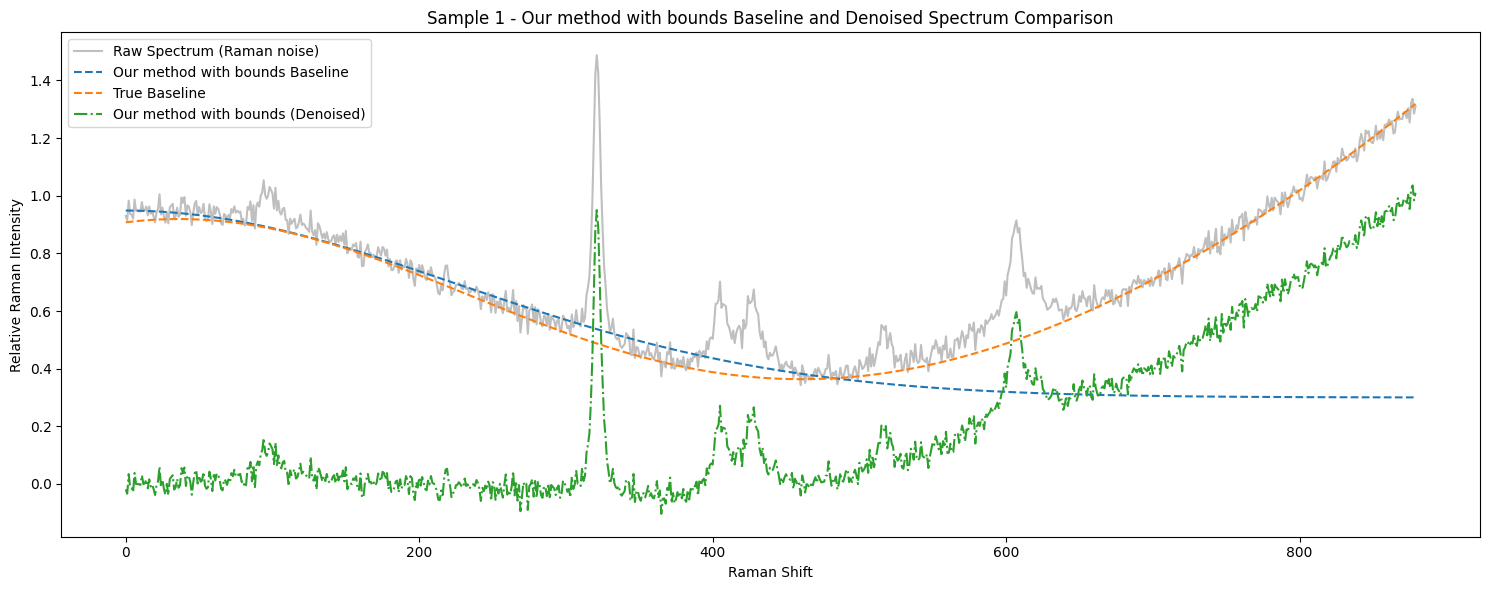

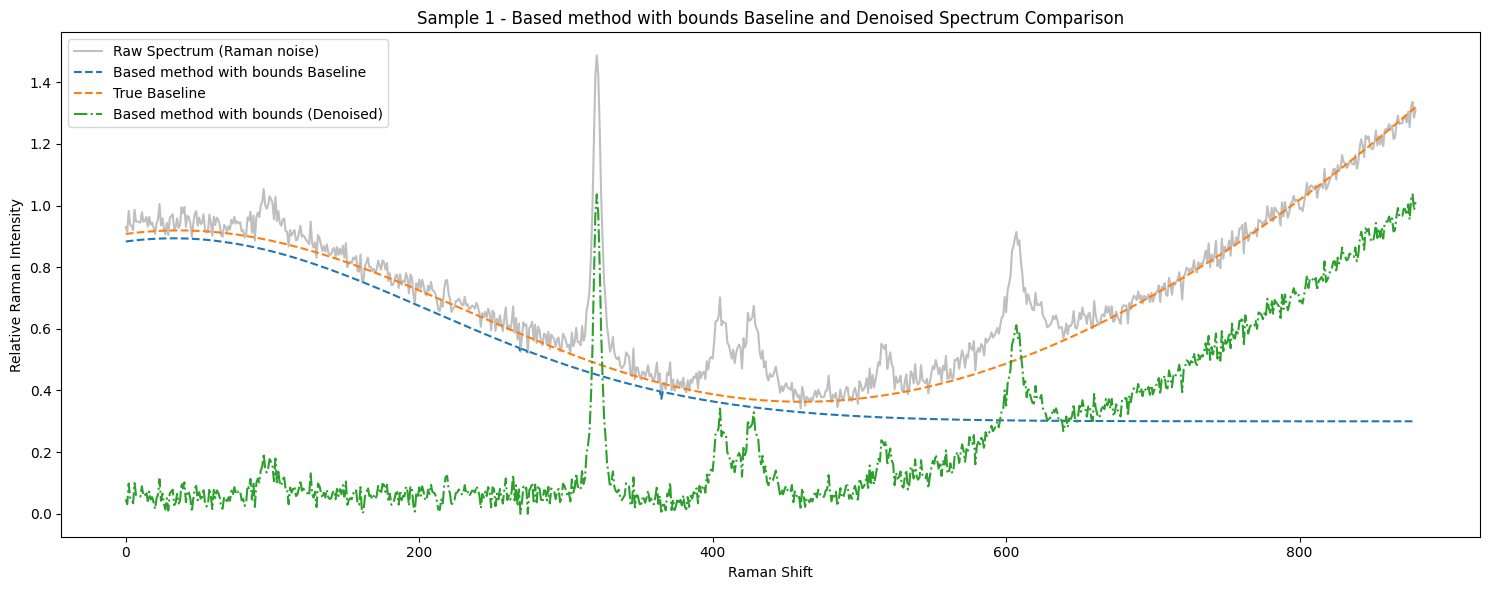

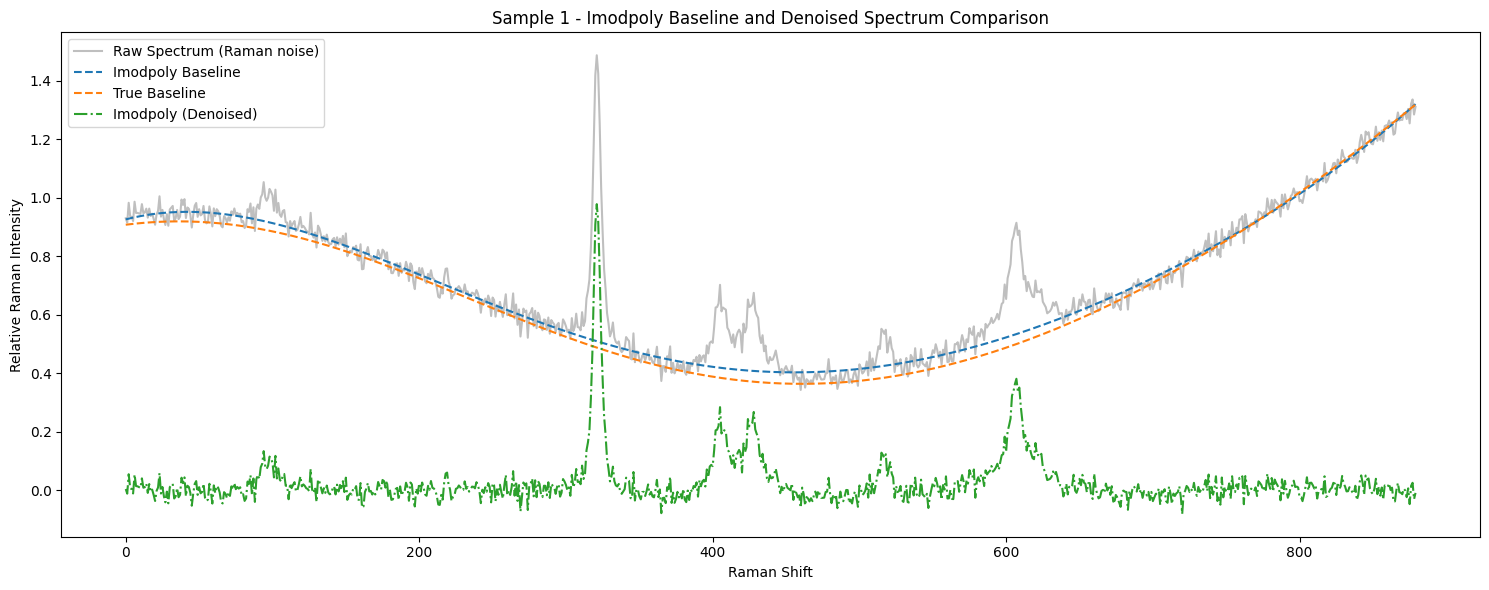

Sample 2:
RMSE - Our method with bounds: 0.0872, Based method with bounds: 0.1413, Imodpoly: 0.0303, airPLS: 0.0962
SNR after Baseline Removal - Our method with bounds: 2.1933, Based method with bounds: 0.8360, Imodpoly: 18.1705, airPLS: 1.8047


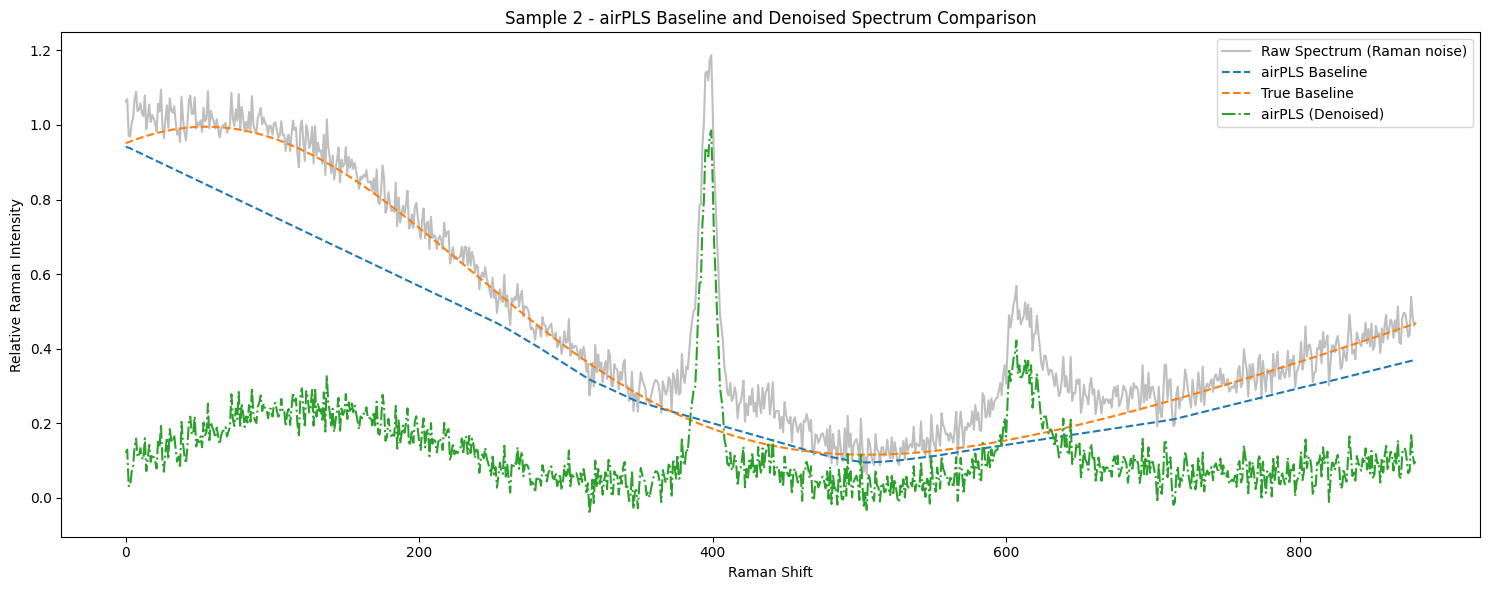

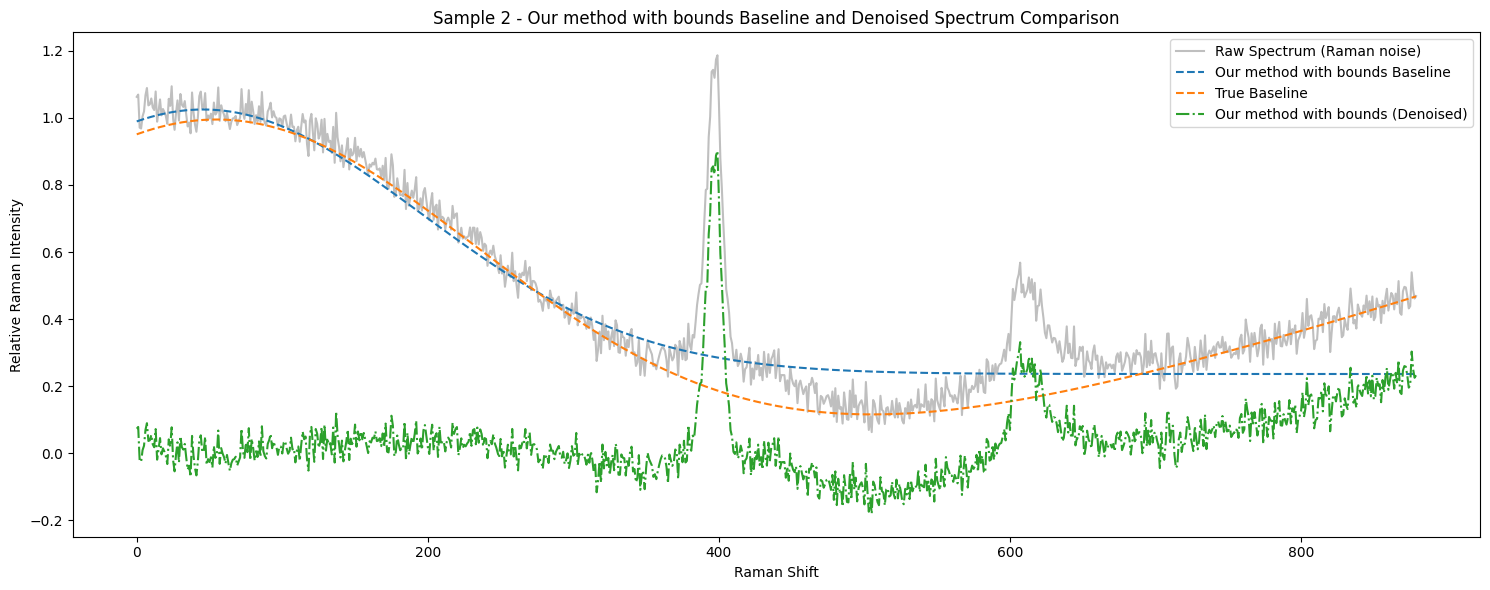

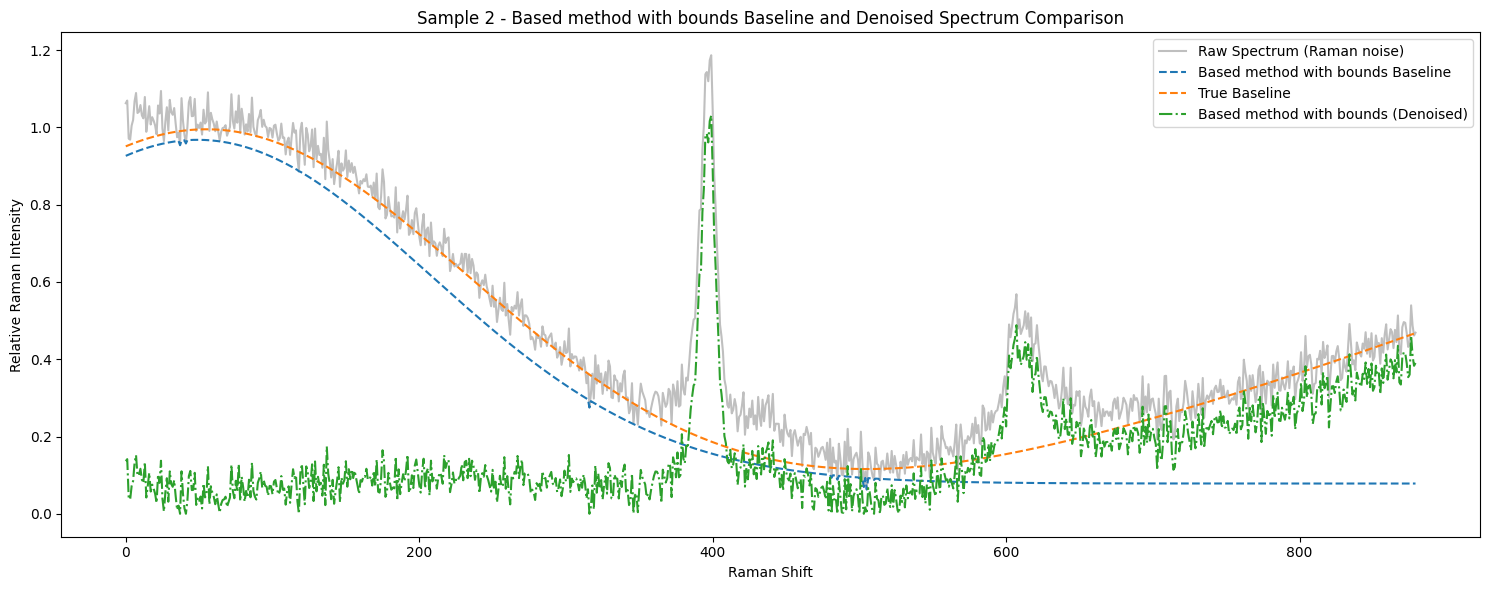

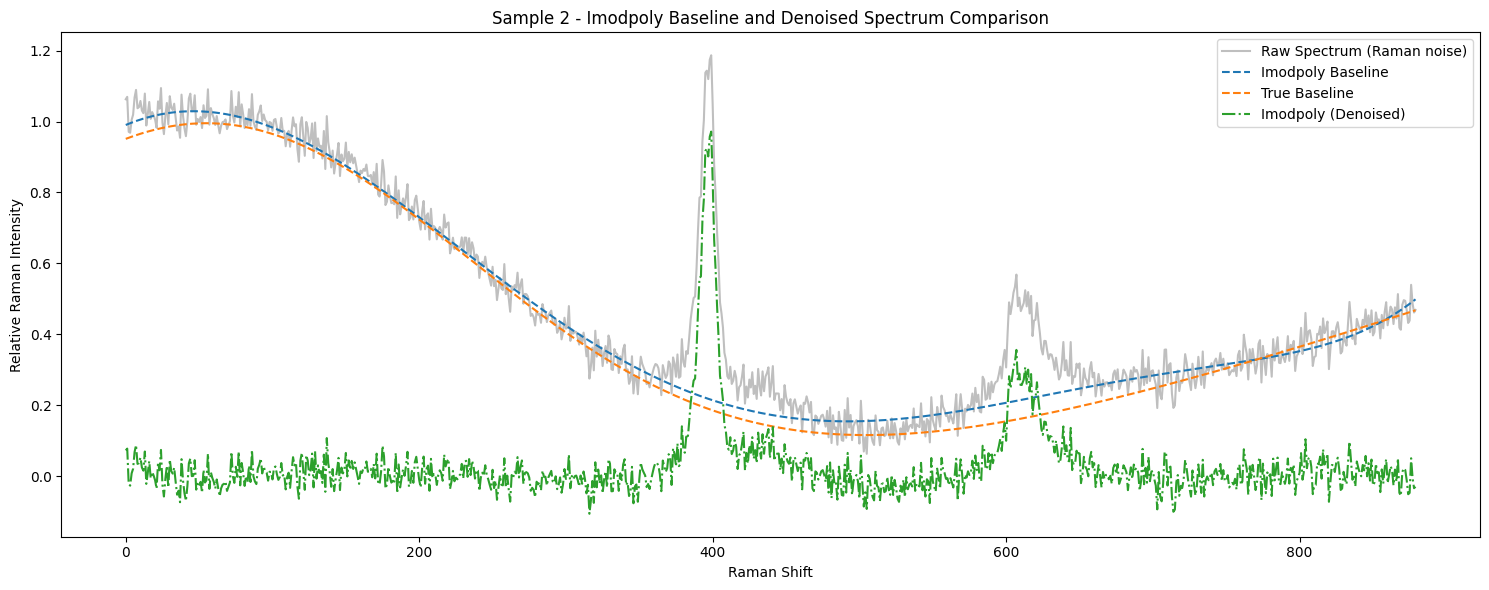

Sample 3:
RMSE - Our method with bounds: 0.3508, Based method with bounds: 0.3716, Imodpoly: 0.0332, airPLS: 0.0385
SNR after Baseline Removal - Our method with bounds: 0.1332, Based method with bounds: 0.1187, Imodpoly: 14.8580, airPLS: 11.0699


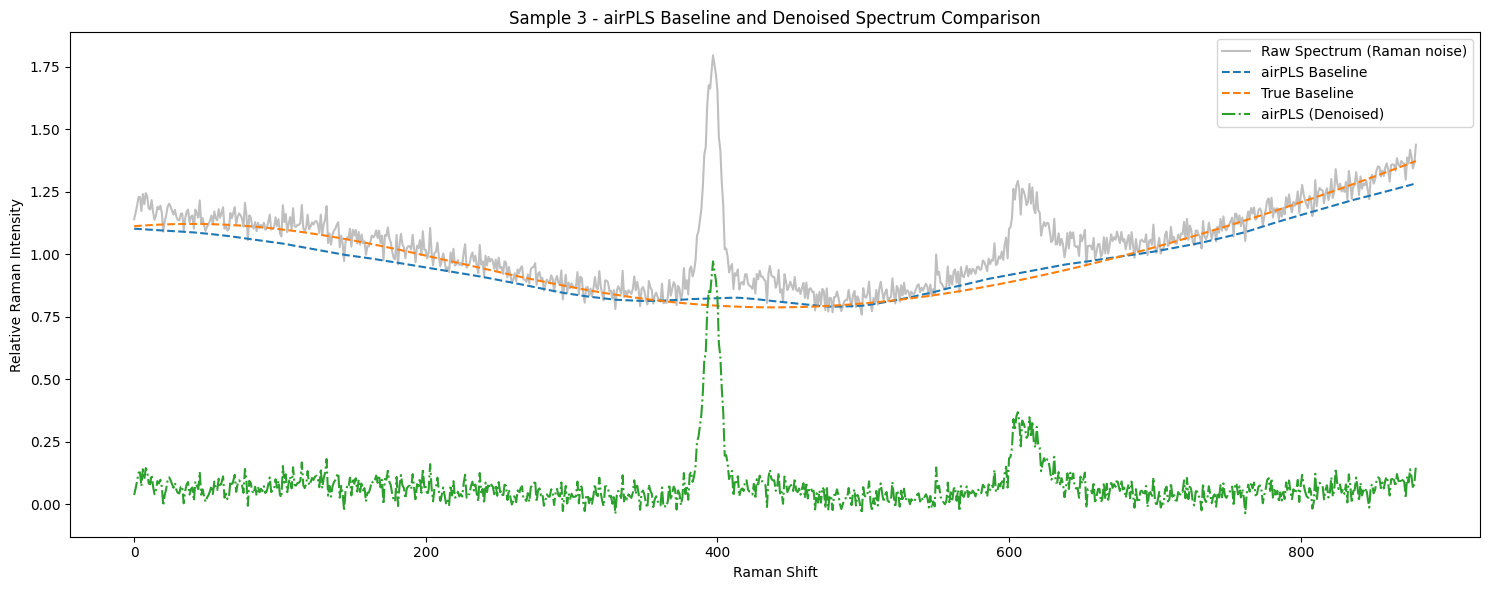

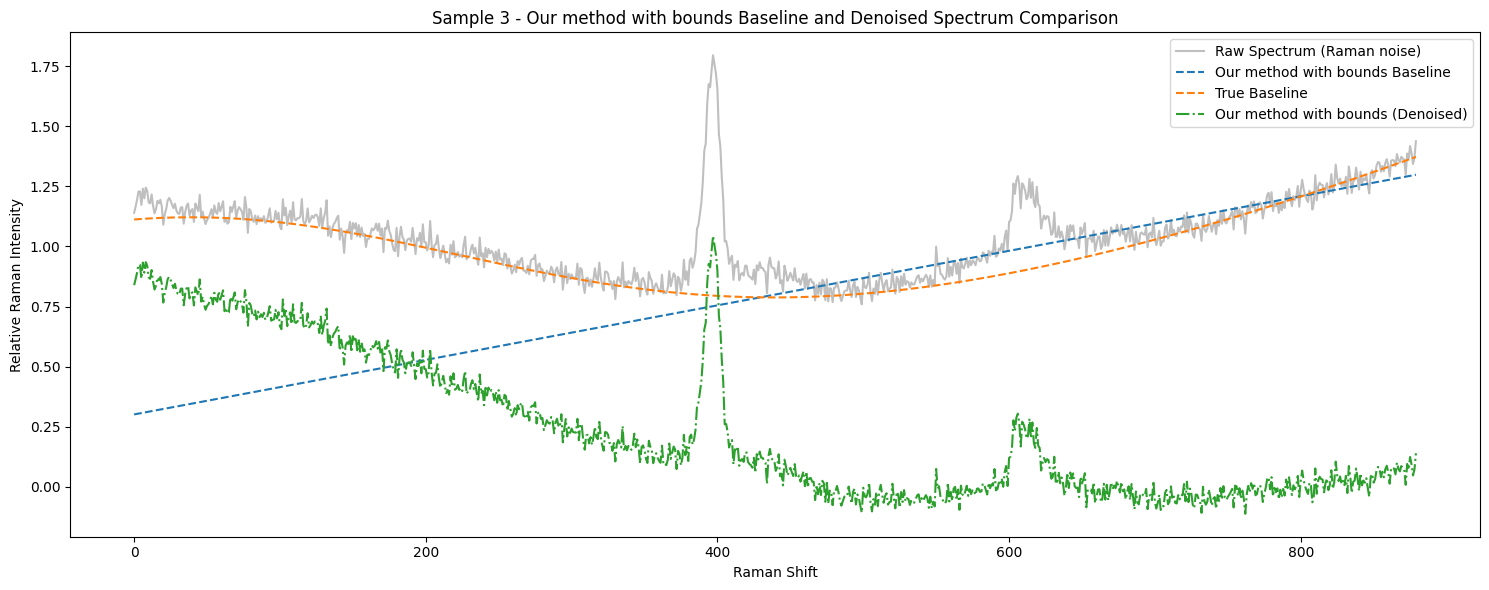

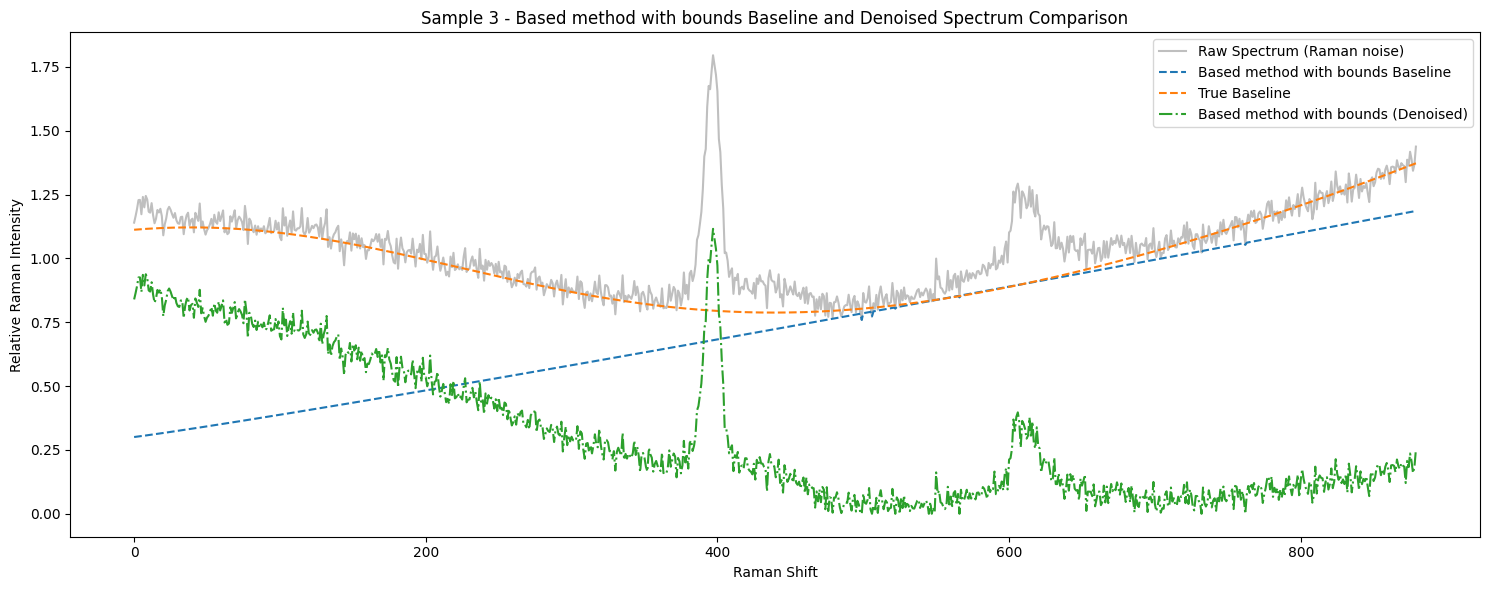

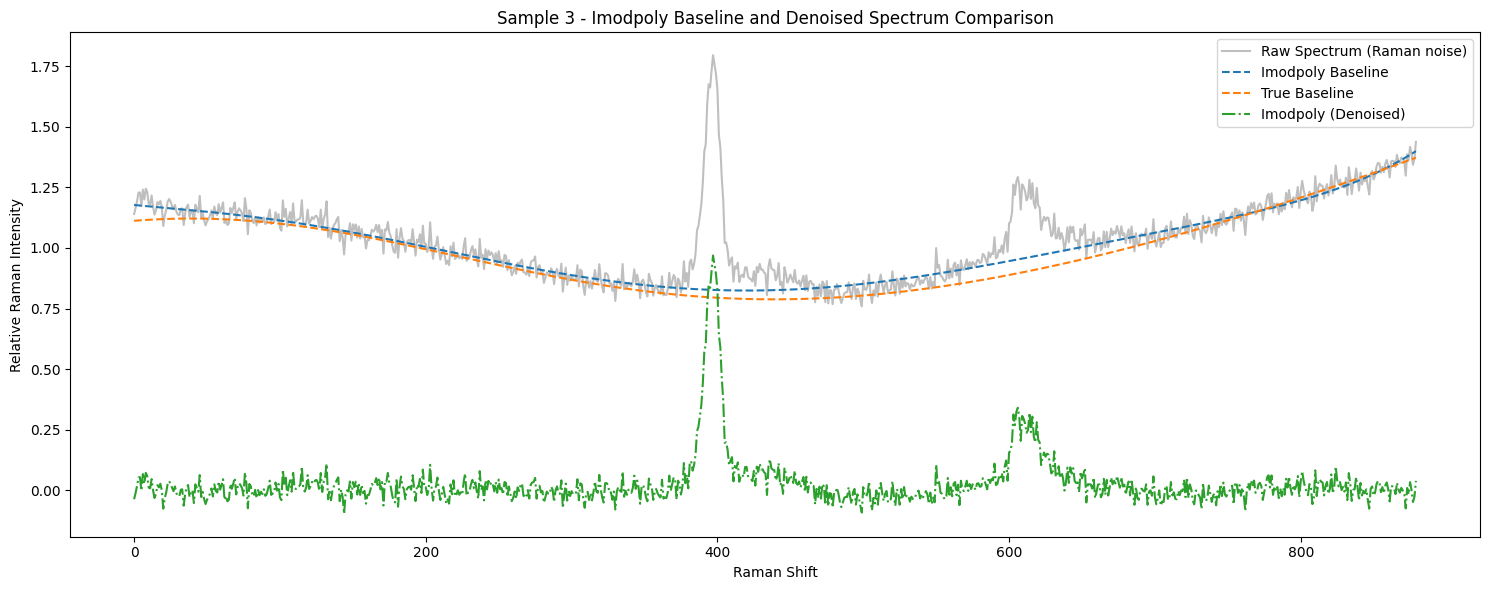

Sample 4:
RMSE - Our method with bounds: 0.0191, Based method with bounds: 0.0530, Imodpoly: 0.0302, airPLS: 0.0337
SNR after Baseline Removal - Our method with bounds: 48.3081, Based method with bounds: 6.3137, Imodpoly: 19.3835, airPLS: 15.5802


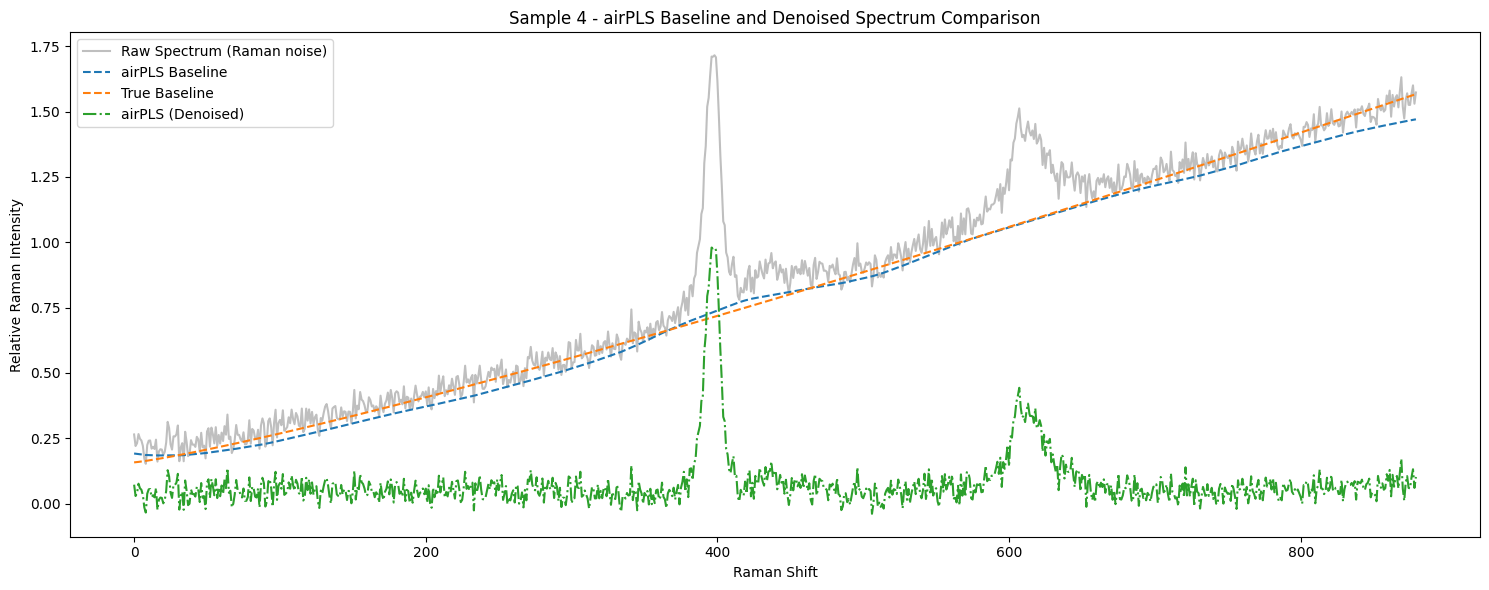

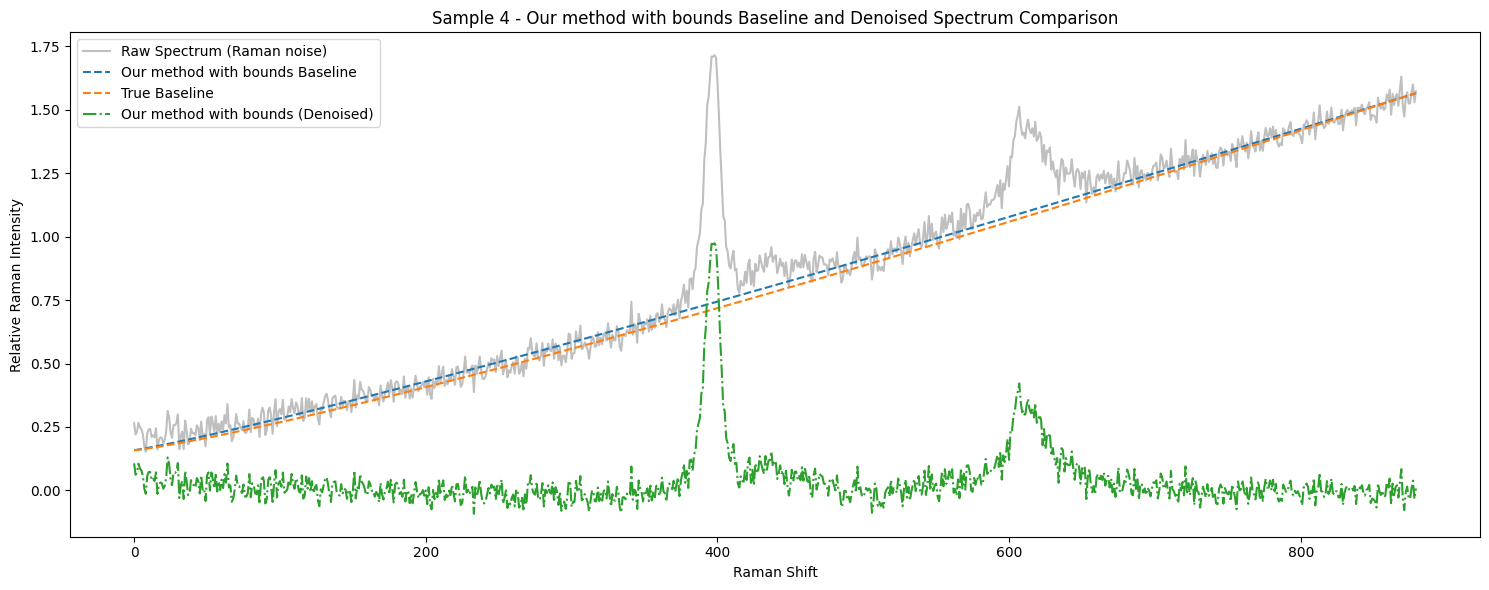

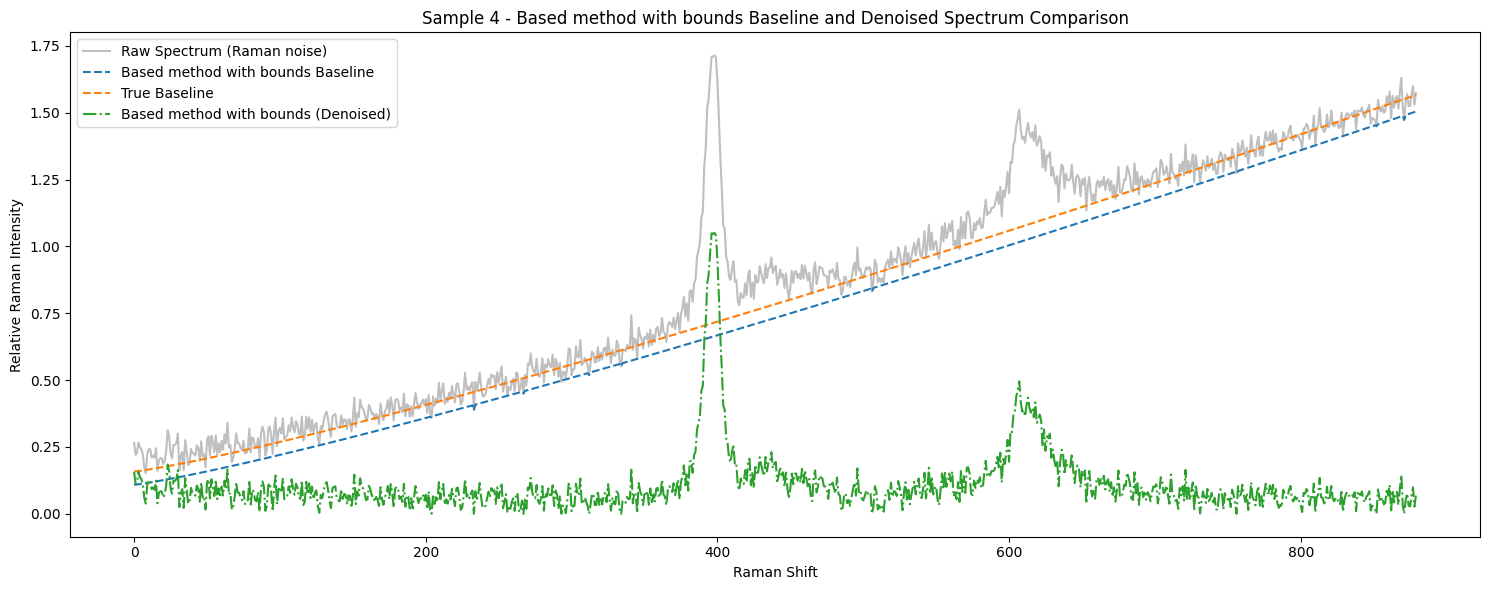

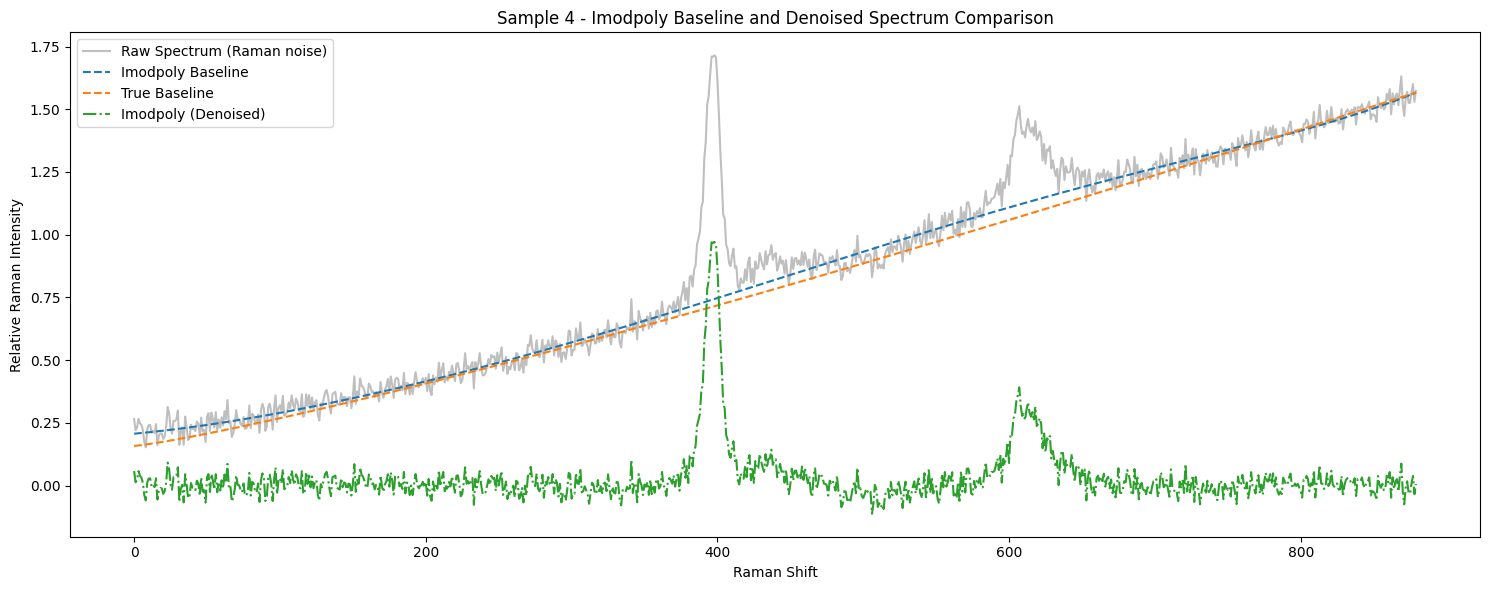

Sample 5:
RMSE - Our method with bounds: 0.2210, Based method with bounds: 0.2807, Imodpoly: 0.0306, airPLS: 0.0463
SNR after Baseline Removal - Our method with bounds: 0.3108, Based method with bounds: 0.1928, Imodpoly: 16.2373, airPLS: 7.0801


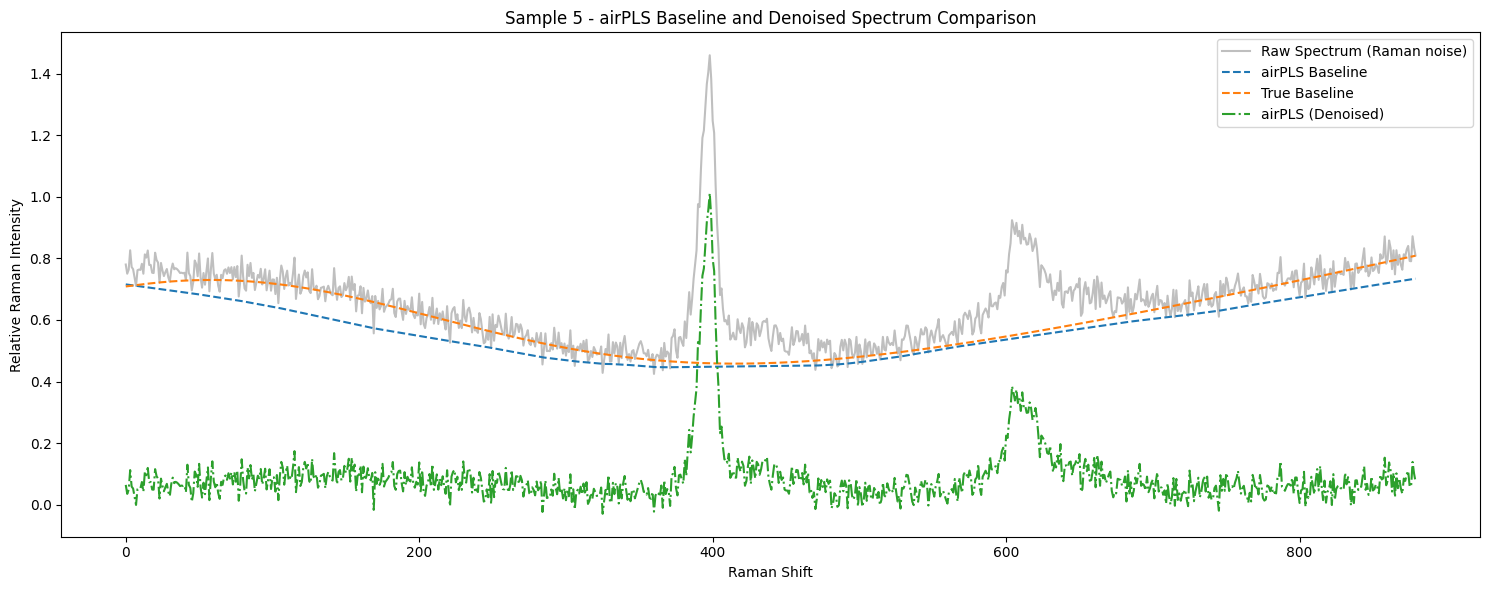

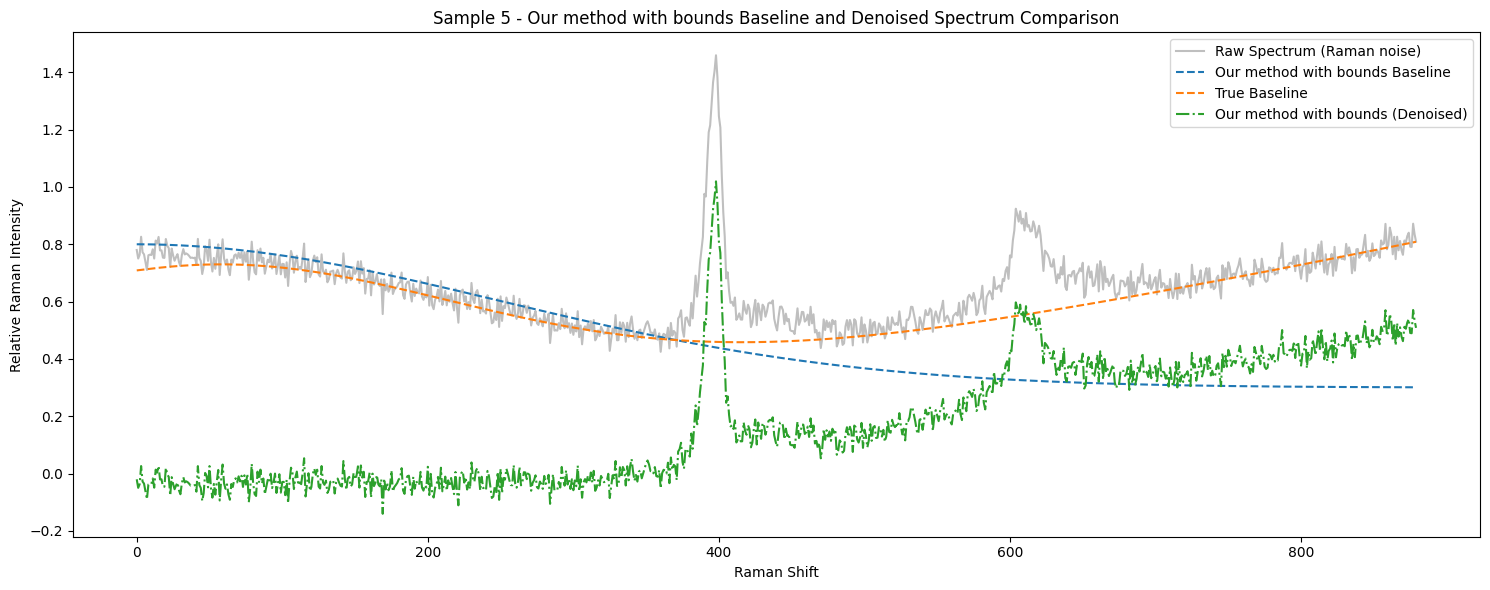

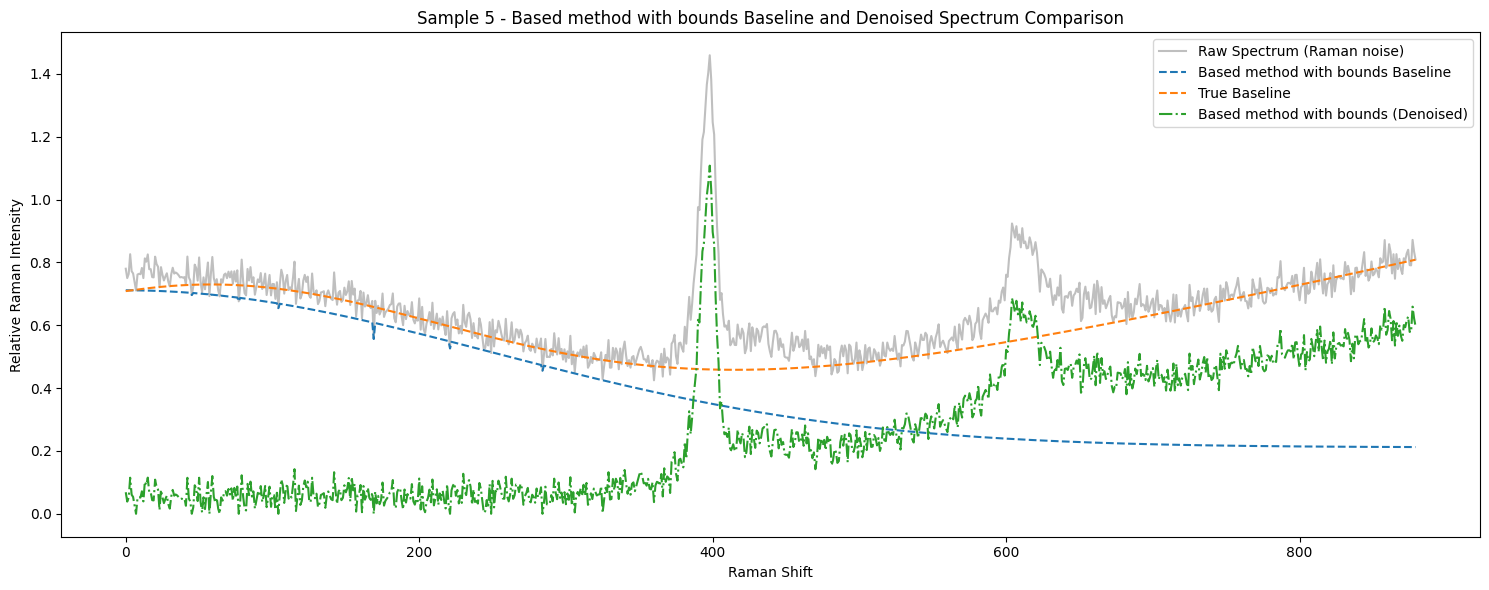

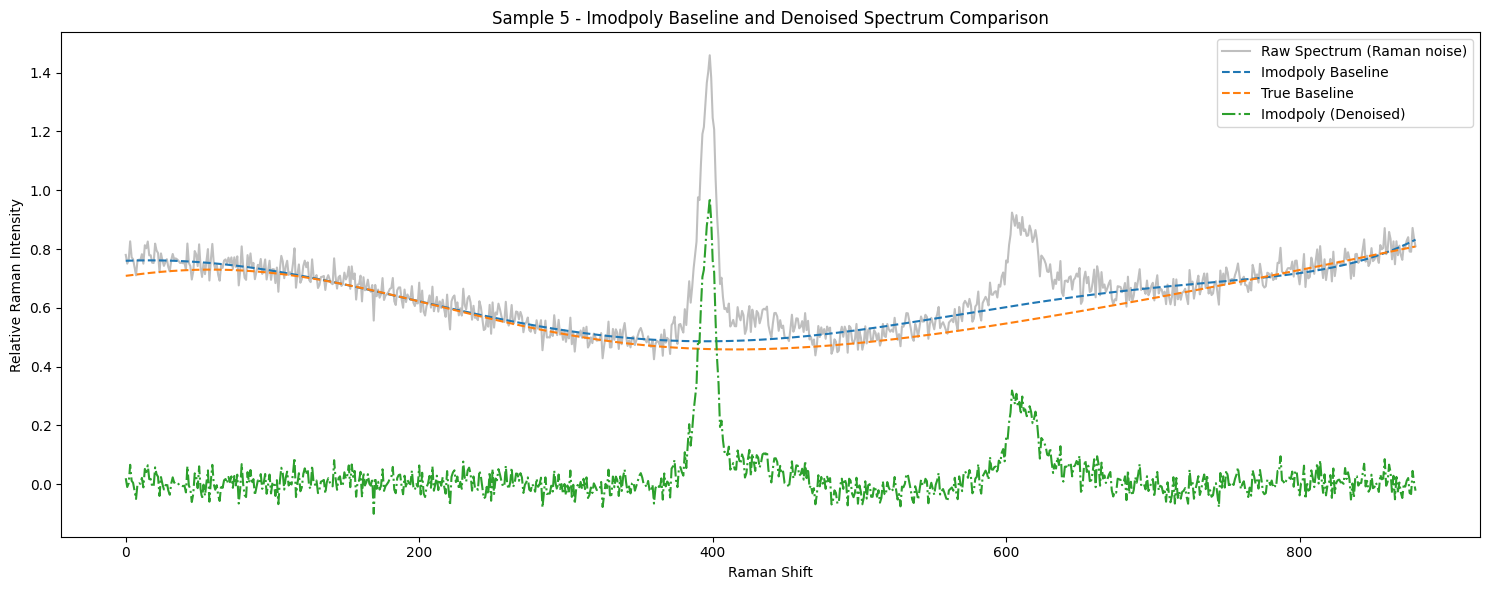

In [100]:
import pybaselines


# RMSE Calculation
def calculate_rmse(signal, baseline):
    return np.sqrt(np.mean((signal - baseline) ** 2))

def calculate_snr(y_s, y_hat):
    numerator = np.sum(y_s ** 2)  
    denominator = np.sum((y_s - y_hat) ** 2) 
    if denominator == 0:
        return float('inf')  
    snr = numerator / denominator
    return snr

# Loop through samples for RMSE and SNR calculations
for i in range(5):
    sample_data = x_train[i]  # Noisy original signal
    true_data = input2[i] / max(input2[i])
    
    # Calculate different baselines
    B = iterative_fitting_with_bounds(sample_data, 100)
    B_1 = iterative_fitting_with_bounds_no(sample_data, 100)
    base_lines2, _ = pybaselines.polynomial.imodpoly(data=sample_data, poly_order=6, max_iter=500)
    B3 = airPLS(sample_data)
    
    # Real baseline
    baseline = baseline_train[i]
    
    # RMSE Calculation
    rmse_B = calculate_rmse(B, baseline)
    rmse_B_1 = calculate_rmse(B_1, baseline)
    rmse_base_lines2 = calculate_rmse(base_lines2, baseline)
    rmse_B3 = calculate_rmse(B3, baseline)
    
    # SNR Calculation for each baseline removal method
    snr_after_baseline_B = calculate_snr(true_data, sample_data - B)
    snr_after_baseline_B_1 = calculate_snr(true_data, sample_data - B_1)
    snr_after_baseline_base_lines2 = calculate_snr(true_data, sample_data - base_lines2)
    snr_after_baseline_B3 = calculate_snr(true_data, sample_data - B3)

    # Print RMSE and SNR values
    print(f"Sample {i+1}:")
    print(f"RMSE - Our method with bounds: {rmse_B:.4f}, Based method with bounds: {rmse_B_1:.4f}, Imodpoly: {rmse_base_lines2:.4f}, airPLS: {rmse_B3:.4f}")
    print(f"SNR after Baseline Removal - Our method with bounds: {snr_after_baseline_B:.4f}, Based method with bounds: {snr_after_baseline_B_1:.4f}, Imodpoly: {snr_after_baseline_base_lines2:.4f}, airPLS: {snr_after_baseline_B3:.4f}\n")

    baselines = {
        "airPLS": B3,
        "Our method with bounds": B,
        "Based method with bounds": B_1,
        "Imodpoly": base_lines2
    }

    for name, baseline_data in baselines.items():
        plt.figure(figsize=(15, 6))
        
        # 1. Plot phổ gốc (raw spectrum)
        plt.plot(sample_data, label="Raw Spectrum (Raman noise)", color="gray", alpha=0.5)
        
        # 2. Plot baseline dự đoán
        plt.plot(baseline_data, label=f"{name} Baseline", linestyle="--")
        plt.plot(baseline, label="True Baseline", linestyle="--")
    
        
        # 3. Plot phổ sau khi trừ baseline (denoised spectrum)
        denoised_spectrum = sample_data - baseline_data
        plt.plot(denoised_spectrum, label=f"{name} (Denoised)", linestyle="-.")
    
        # Thiết lập nhãn và tiêu đề
        plt.xlabel("Raman Shift")
        plt.ylabel("Relative Raman Intensity")
        plt.legend()
        plt.title(f"Sample {i+1} - {name} Baseline and Denoised Spectrum Comparison")
        plt.tight_layout()  
        plt.show()
        plt.close()  
